#### Adapted from https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34

In [1]:
pip install keras

In [2]:
pip install scikit-learn

In [3]:
pip install matplotlib

In [4]:
pip install tensorflow

In [ ]:
pip install PIL

In [ ]:
pip install pandas

In [2]:
# for loading/processing the images  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
import PIL

In [3]:
def get_images(path_to_images, filetype):  ##path should be the path to the folder which contains the images, filetype should be either '.jpg' or '.png'
    os.chdir(path_to_images)
    # this list holds the filenames for all the images in the folder
    images = [] 
    # creates a ScandirIterator aliased as files
    with os.scandir(path_to_images) as files:
    # loops through each file in the directory
        for file in files:
            if file.name.endswith(filetype):
            # adds only the image files to the flowers list
                images.append(file.name)
    return images

In [4]:
def VGG_model(vgg_model_choice): ## choose either VGG16() or VGG19()
    # load model
    model = vgg_model_choice
    # remove the output layer
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    return model

In [14]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [19]:
def get_feature_array(image_set,vgg_model): # image set should be output from get_images(), vgg_model should be output from VGG_model()
    data = {}
    # loop through each image in the dataset
    for image in image_set:
        # try to extract the features and update the dictionary
        try:
            feat = extract_features(image,vgg_model) 
            data[image] = feat   
        except: 
            pass    
    # get a list of the filenames
    filenames = np.array(list(data.keys()))

    # get a list of the features for each image file
    feat = np.array(list(data.values()))
    feat.shape
    (210, 1, 4096)

    # reshape so that there are 210 samples of 4096 vectors
    feat = feat.reshape(-1,4096)
    feat.shape
    (210, 4096)

    return filenames, feat


### Below cell can be used for saving/loading from saved the results from the VGG model so they can be accessed without re-running the model. Uncomment out if requried

In [ ]:
#Use this to save the features and filenames. Replace with desired path to files

# pd.DataFrame(feat).to_csv(PATH TO SAVE FEATURES)
# pd.DataFrame(filenames).to_csv(PATH TO SAVE FILENAMES)

#Use this to load saved features and filenames for use with the PCA + KMeans clustering. Replace with path to files

#feat = pd.read_csv(FEATURE PATH).to_numpy()
#filenames = pd.read_csv(FILENAMES PATH).to_numpy()

# feat = feat.iloc[:,-4096:].to_numpy()
# filenames=filenames.iloc[:,-1].to_numpy()

In [21]:
#Apply PCA to reduce feature space (change "feat" to whatever you have named the feat output from get_feature_array()). Change n_components and random state as required
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [23]:
#Perform kmeans clustering. Change n_clusters and random state as required
kmeans = KMeans(n_init = 'auto',n_clusters=40, random_state=22)
kmeans.fit(x)

# holds the cluster number and the images { number: [images] } (change "filenames" to whatever you have named the filenames output from get_feature_array())
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [24]:
# function that lets you view a cluster (based on cluster number)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time. Adjust or remove as desired
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

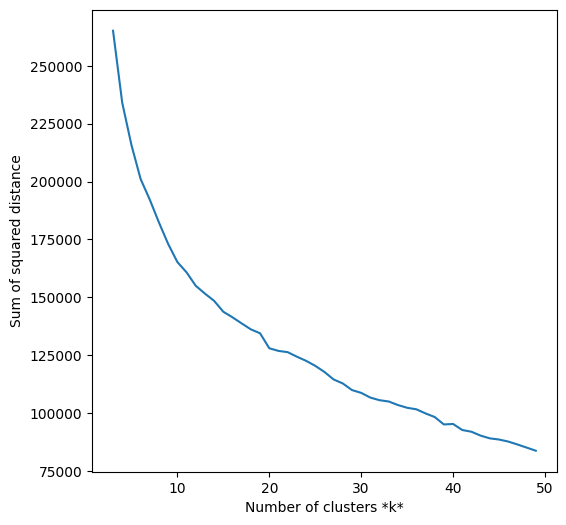

In [68]:
# this is for if you want to investigate which value for k might be the best via the elbow method
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_init = 'auto', n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
        